# Step4 演習04 ロジスティック回帰からニューラルネットへ
---

Step4では手書き数字の認識(Optical Character Recognition; OCR)を実装します。

まずはロジスティック回帰で実装を行い、モデルやパラメータを変更することによってスコアへどのような影響があるか体験してもらいます。

今回はscikit-learnを利用して実装を行います。

OCRはマルチクラス分類問題ですが、scikit-learnの`LogisticRegression()`を使うとオプションなしで一対多分類器として動いてくれるため、とても簡単にOCRを実装できます。

次に、ニューラルネットワークでロジスティック回帰を実装します。

多層のニューラルネットワークへの学習（ディープラーニング）もパラメータを変えるだけで実現できるので、学習にかかる時間とスコアの違いを身をもって体感してください。

**はじめに**
- for文やwhile文の利用は明示的な利用指示がない場所での使用は避けてください。

**本演習の目的**
- 多項式で特徴の数を増やすことによって訓練データ以外のスコアの改善を試みる。

## ライブラリのインポート

まずはじめに、利用するライブラリのインポートを行います。

- [numpy](http://www.numpy.org) 数値計算を行うための基本パッケージの公式ドキュメント
- [matplotlib](http://matplotlib.org) グラフ描画ライブラリの基本パッケージの公式ドキュメント
- [scikit-learn](http://scikit-learn.org/stable/index.html) Pythonのオープンソース機械学習ライブラリの公式ドキュメント

ドキュメントには有用な情報が書き記されています。何か迷ったときには必ずドキュメントに戻ってくるようにしましょう。

次のセルをそのまま実行（"SHIFT" + "ENTER"）してください。コードが書いてあるセルは**上から順番に**順次実行してください。

** 注意： **初めてmatplotlibを使うユーザーは、フォント一覧のキャッシュが存在しないため、このセルの実行でWarningが出ます。もう一度実行すると、すでにキャッシュができているので、Warningなく走ります。

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
font = {'family':'IPAexGothic'}
plt.rc('font', **font)

## 今回使うデータに関して
数字OCRのサンプルデータとしてMNISTが有名です。MNISTは手書き数字の画像のデータセットになっています。機械学習業界の"Hello, world!"ということができるでしょう。これからMNISTとはいったいどういったものなのか使用するデータの性質をみていきましょう。

「0」から「9」までの10種類の数字をこれから判別します。

In [4]:
num_labels = 10 #「0」から「9」の数字をこれから判別します。

## MNISTデータのロード
データをロードします。
mldata.orgからMNIST originalデータをダウンロードします。使用している回線によっては時間がかかる場合があります。

一度ダウンロードしたらキャッシュしますので、再度走らせるときはダウンロードの時間がかかりません。

In [5]:
mnist = datasets.fetch_mldata('MNIST original')

今回使用するMNISTの画像の枚数は70000枚、画像データのと特徴は28x28 = 784ピクセルです。

- 画像データの数：70000枚
- 画像データの特徴：28x28 = 784ピクセル

下のセルを実行することで画像データの数を** num_data **に、画像データの特徴を** input_layer_size  ** にそれぞれ格納します。


In [6]:
num_data, input_layer_size = mnist.data.shape #70000枚の28x28=784ピクセルの画像です

In [7]:
print("訓練データ数：{}".format(num_data))
print("訓練データの特徴の数：{}".format(input_layer_size))

訓練データ数：70000
訓練データの特徴の数：784


## データのシャッフル
MNIST originalデータをシャッフルしてその冒頭3000サンプルだけ訓練データとして利用することにします。

今回使用するMNISTデータのサンプル数は70000です。この全てを訓練データとして使ってしまうと、学習に使用しなかったデータに対しても正しく予測してくれるのか判断する方法がなくなってしまいます。試作段階では全てのデータを学習に用いてはいけません。（詳しくはStep5で学びます）

また今回10分の1未満のデータせセットしか学習に使わないのは別の理由もあります。マシンスペックの関係で、膨大なデータを用いると学習がなかなか終わらないためです。今回は3000サンプルのみを使用します。

ここで3000サンプルをピックアップする前にデータをシャッフルするのは何故でしょうか。例えば、データがラベル(y)に対してソートされていたとします。すると、そのまま冒頭3000サンプルを取ってしまうと、0, 1と書いてあるデータばかりが集まってしまうことになってしまいます。ぱっと見で分からないような規則でソートされている可能性もあるので、一見バラバラに見えても必ず最初にシャッフルしましょう。

下のセルを実行すると3000サンプルをランダムにシャッフルしたデータを、** X ** と ** y ** にそれぞれ格納してくれます。

In [8]:
shuffle_idx = np.random.permutation(num_data)
X = mnist.data[shuffle_idx[:3000]]   # ランダム化された画像データ3000枚
y = mnist.target[shuffle_idx[:3000]] # 各画像（3000枚）に書かれている数字（「正しい答え」）

データのシャッフルはscikit-learnのtrain_test_splitを使うこともできます。これは訓練用のデータとテスト用のデータを分けてくれるので便利です。習熟したらscikit-learnチュートリアルを読んでこれを使いましょう。

参考：
[scikit-learnチュートリアル sklearn.cross_validation.train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html#sklearn.cross_validation.train_test_split)

訓練例の数(3000個)は`m`、特徴の数(784ピクセル)は`n`に格納します。

In [9]:
m, n = X.shape #訓練例の数はm, 特徴の数はn

In [10]:
print("訓練例の数：{}".format(m))
print("特徴の数：{}".format(n))

訓練例の数：3000
特徴の数：784


## データの視覚化
使用するデータの準備ができました。ここではランダムに並べた最初の画像を表示させてみます。

配列`X`には3000枚の画像データ(pixel)が、一列に並んで入っています。（`X`の`shape`は`(3000, 784)`）

この画像を表示させるには、一列に並んでしまっている`3000`枚の画像データをそれぞれ２次元`(28, 28)`に戻す必要があります。それには`reshape`を使います。

下の画像は一枚の数字データに対してreshapeを行なったイメージ図です。

<div align="center"  style="width:70%">
<img src="./dataStep4/img_reshape.png"></div>

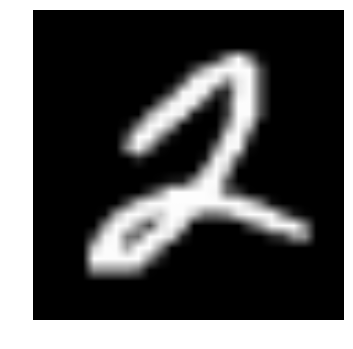

数字 2


In [11]:
X_reshaped = X.reshape((3000, 28, 28))

plt.imshow(X_reshaped[0,:,:])
plt.axis("off")
plt.gray()
plt.show()

print("数字 {0:1.0f}".format(y[0]))

一つだけでは見栄えがしないので、100個表示させるプログラムを関数（ `displayData(images)` ）として実装しておきましょう。

In [12]:
def displayData(images):
    images_reshaped = images.reshape((100, 28, 28))
    for i in range(100):
        plt.subplot(10,10,i+1)
        plt.imshow(images_reshaped[i,:,:])
        plt.axis("off")
        plt.gray()
    plt.show()

これを使って、訓練データから冒頭100個選んで視覚化しましょう。多少表示に時間がかかります。

セルの左、In [何某]のところが＊になっているとき、そのセルは実行中です。

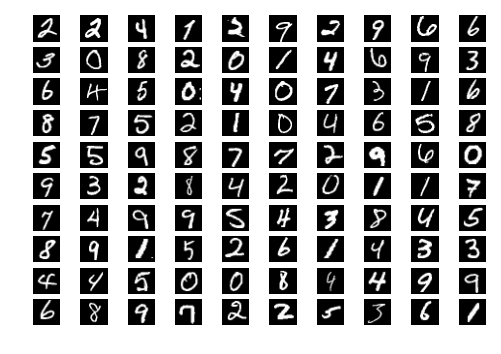

In [13]:
displayData(X[:100, :])

---
## 決定境界が非線形なモデルを使ってみる（多項式で特徴を増やす）

なかなか訓練例以外の新しいデータ（未知のデータ）に対するスコアが上がってくれません。一体どうすれば良いのでしょうか？

一つの方策として多項式で特徴を増やしてみましょう。

### 実装する前に思い出してほしい多項式で特徴を増やすデメリット
その前に、多項式の仮説にするとどのようなデメリットが生じるか思い出しましょう。

例えば2次の仮説を立てたとします。今回は28x28=784ピクセルの画像が入力データでしたから、特徴の数は784個。2次の仮説を立てると特徴の数は$_{784}C_2 = \frac{784 \times (784-1)}{2}=306936$個となります。今ベンチマークに使っているMNISTの手書き数字データは学習に使っていない分を含めても70000個程度ですから、特徴の数の方が訓練例の数よりも遥かに多い。つまりデータフィットに用いるパラメータが多すぎるため、確実に<font color='red'>**オーバーフィット**<font color='black'>してしまいます。

### モデルを立てる
どう考えても無理筋であることはコードを書く前から分かっていますが、試しにやってみましょう。30万個の特徴を扱うため、学習に時間がかかります。全てのMNISTデータを学習に利用してもまず上手くいかないことは分かっていますが、試しに500個だけ学習させてみましょう。

参考：
[scikit-learnチュートリアル sklearn.pipeline.Pipeline()](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

In [14]:
fit_iter = 50 #勾配法の繰返し回数

In [15]:
X1_train = mnist.data[shuffle_idx[0:500]] #学習時間削減のため500個だけ対象にする
y1_train = mnist.target[shuffle_idx[0:500]]
X1_CV = mnist.data[shuffle_idx[500:1000]]
y1_CV = mnist.target[shuffle_idx[500:1000]]

In [ ]:
estimator_poly = Pipeline([('poly', PolynomialFeatures(degree=2)), \
                           ('linear', LogisticRegression(penalty='l2', C=10, max_iter=fit_iter))])

In [ ]:
estimator_poly.fit(X1_train,y1_train)
score_poly_train = estimator_poly.score(X1_train,y1_train)
score_poly_CV = estimator_poly.score(X1_CV,y1_CV)
print("学習スコアは",score_poly_train,"、交差検証スコアは",score_poly_CV)

### 訓練例をふやしてみよう
訓練例の数を変化させながら、スコアをプロットしたものである学習曲線を見てみたいところなのですが、何分学習に時間がかかるので、１回だけ個数を増やしてみるに留めたいと思います。

**【課題５】** 2次の多項式を仮説としたロジスティック回帰をモデルとし、訓練例の数を1000個としたときのスコアを求めましょう。

<u>注意</u> 学習にとても時間がかかります。ここでコーヒーブレイクをしましょう。

In [ ]:
#Coursemale-02 Step4 QuestionNumber5 8f55726d7a2ea8014f7a38045d6e519a
###############ここを穴埋めしてください###############
#適切な 関数・変数・値 などにNoneを書き換えてください。
X2_train = mnist.data[shuffle_idx[0:1000]]
y2_train = mnist.target[shuffle_idx[0:1000]]
X2_CV = mnist.data[shuffle_idx[1000:1500]]
y2_CV = mnist.target[shuffle_idx[1000:1500]]
estimator_poly.fit(X2_train,y2_train)
score_poly_train2 = estimator_poly.score(X2_train,y2_train)
score_poly_CV2 = estimator_poly.score(X2_CV,y2_CV)
print("学習スコアは",score_poly_train2,"、交差検証スコアは",score_poly_CV2)
######################################################

左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [ ]:
%%bash
./validation_client.py male-02 4 5 Step4_04.ipynb api.internal.zero2one.jp

線形の仮説に比べると一線を越えた感じがします。仮説を線形にしていたところが問題だったようです。

もし線形の仮説にさらに大量のデータを用いて学習させたら、どんどん学習スコアも落ちてくるでしょう。（時間と計算資源に余裕があれば、やってみてください。）このように、狭すぎる仮説を立てたが故に学習スコアも落ちてしまうことを**アンダーフィッティング**といいます。

しかし、多項式などによって特徴を大量に増やしすぎた仮説を用いると**オーバーフィッティング**してしまうことは先ほど説明しました。（参照：[実装する前に思い出してほしい多項式で特徴を増やすデメリット](#実装する前に思い出してほしい多項式で特徴を増やすデメリット)）

これでは一定以上のパフォーマンスを望めません。

### （発展）最適化アルゴリズム
特徴の数や訓練例の数が増えると非常に遅くなることが分かりました。その一つのネックとなっているのが、メモリーの大量消費です。スワップアウトが発生し、遅くなってしまうのです。最適化アルゴリズムによっては、使用メモリーが少ないもの（PolakとRibiereによるCG法など）もあります。scikit-learnのチュートリアルや、scipyのoptimizarのチュートリアルなどを読んで、色々な最適化アルゴリズムがあるということを体感しよう。また、余力があれば、実装してみよう。

※スワップアウト…メインメモリでは容量が足りないため、あまり使わないデータを中心にあらかじめ一時的にハードディスクに移すこと。メモリーへの読み書きに比べてハードディスクやSSDへの読み書きは桁違いに遅いため、もし今使用しようとしているデータまでスワップアウトされてしまうとパフォーマンスの大幅低下につながる。

最適化アルゴリズムの参考：

[Scikit-learnチュートリアル sklearn.linear_model.LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

[Scipyチュートリアル Optimization and root finding](http://docs.scipy.org/doc/scipy/reference/optimize.html)